In [ ]:
%matplotlib inline
import pymc3 as pm
import theano.tensor as T
import theano
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.cross_validation import train_test_split
from sklearn.datasets import make_moons

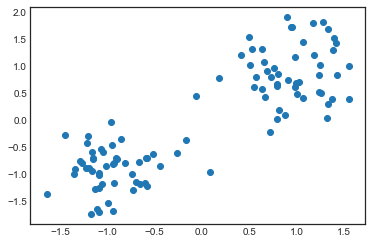

In [4]:
X, Y = sklearn.datasets.make_blobs(centers=2, random_state=3)
X = scale(X)
plt.scatter(X[:, 0], X[:, 1])

In [7]:
X_unc = np.ones_like(X) * 1.
X_unc[:, 0] = .5

In [8]:
prob.tag.test_value.shape

NameError: name 'prob' is not defined

In [10]:
prob.tag.test_value.shape

(100, 2)

In [11]:
with pm.Model() as logistic_regression:
    inputs = pm.Normal('inputs', mu=X, sd=X_unc, shape=X.shape)
    coeffs = pm.Normal('beta', mu=0, sd=1, shape=2)
    
    linear = pm.math.dot(inputs, coeffs)
    prob = pm.math.sigmoid(linear)
    obs = pm.Bernoulli('obs', p=prob, observed=Y)
    
    # Run ADVI which returns posterior means, standard deviations, and the evidence lower bound (ELBO)
    mean_field = pm.fit(method='advi', n=50000,
                        callbacks=[pm.callbacks.CheckParametersConvergence(diff='relative')])
    
    out_sample = (mean_field.sample_node(prob, size=100, more_replacements={inputs: grid_2d}) > .5)

Average Loss = 18.646: 100%|██████████| 50000/50000 [00:36<00:00, 1370.77it/s]
Finished [100%]: Average Loss = 18.653


NameError: name 'grid_2d' is not defined

In [ ]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 6))
#contour = ax.contourf(X1_grid, X2_grid, out_sample.eval().std(axis=0).reshape(100, 100), cmap=cmap)
contour = ax.contourf(X1_grid, X2_grid, out_sample.eval().mean(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X[Y==0, 0], X[Y==0, 1])
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X1', ylabel='X2');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');

In [ ]:
cmap = sns.choose_light_palette(250, 12)#, as_cmap=True)#, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 6))
contour = ax.contourf(X1_grid, X2_grid, out_sample.eval().std(axis=0).reshape(100, 100), cmap=cmap)
#contour = ax.contourf(X1_grid, X2_grid, out_sample.eval().mean(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X[Y==0, 0], X[Y==0, 1])
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X1', ylabel='X2');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');

In [ ]:
X, Y = make_moons(noise=0.2, random_state=0, n_samples=1000)
X = scale(X)
def uncertainty_surf(x, a=(2, 3), b=(.2, .3), min_val=.1):
    out_1 = a[0] + x[:, 0] * b[0] 
    out_2 = a[1] + x[:, 1] * b[1]
    out_1[out_1 < min_val] = min_val
    out_2[out_2 < min_val] = min_val
    return np.dstack([out_1, out_2])[0, ...]
X.shape

In [ ]:
X_uc = uncertainty_surf(X)
X_uc.shape
(1000, 2)
fig, ax = plt.subplots()
ax.scatter(X[Y==0, 0], X[Y==0, 1], label='Y=0')
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Y=1')
sns.despine(); ax.legend()
ax.set(xlabel='X1', ylabel='X2', title='Toy binary classification data set');

In [ ]:
X_uc

In [ ]:
plt.plot(X[:, 0], X_uc[:, 0])

In [ ]:
fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1], linewidths=X_uc[])
sns.despine(); ax.legend()
ax.set(xlabel='X1', ylabel='X2', title='Toy binary classification data set');

In [ ]:
out_sample.eval().shape


In [ ]:
n_hidden = 5

# Initialize random weights between each layer
init_1 = np.random.randn(X.shape[1], n_hidden)
init_2 = np.random.randn(n_hidden, n_hidden)
init_out = np.random.randn(n_hidden)

#input_dist = theano.shared(X)

with pm.Model() as neural_network:
    input_dist = pm.Normal('inputs', mu=X, sd=X_uc*.1, 
                           shape=X.shape)
    
    # Weights from input to hidden layer
    weights_in_1 = pm.Normal('w_in_1', 0, sd=1, 
                             shape=(X.shape[1], n_hidden), 
                             testval=init_1)
    
    # Weights from 1st to 2nd layer
    weights_1_2 = pm.Normal('w_1_2', 0, sd=1, 
                            shape=(n_hidden, n_hidden), 
                            testval=init_2)
    
    # Weights from hidden lay2er to output
    weights_2_out = pm.Normal('w_2_out', 0, sd=1, 
                              shape=(n_hidden,), 
                              testval=init_out)
    
    # Build neural-network using tanh activation function
    act_1 = T.tanh(T.dot(input_dist, 
                         weights_in_1))
    act_2 = T.tanh(T.dot(act_1, 
                         weights_1_2))
    act_out = T.nnet.sigmoid(T.dot(act_2, 
                                   weights_2_out))
    
    # Binary classification -> Bernoulli likelihood
    out = pm.Bernoulli('out', 
                       act_out,
                       observed=Y)

In [ ]:
with neural_network:
    # Run ADVI which returns posterior means, standard deviations, and the evidence lower bound (ELBO)
    mean_field = pm.fit(method='advi', n=50000,
                        callbacks=[pm.callbacks.CheckParametersConvergence(diff='relative')])

In [ ]:
plt.plot(mean_field.hist);

In [ ]:
grid = np.mgrid[-3:3:100j,-3:3:100j]
grid_2d = grid.reshape(2, -1).T
X1_grid, X2_grid = grid
with neural_network:
    out_sample = (mean_field.sample_node(act_out, size=100, more_replacements={input_dist: grid_2d}) > .5)
out_sample.eval().std(axis=0)

In [ ]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 6))
contour = ax.contourf(X1_grid, X2_grid, out_sample.eval().std(axis=0).reshape(100, 100), cmap=cmap)
#contour = ax.contourf(X1_grid, X2_grid, out_sample.eval().mean(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X[Y==0, 0], X[Y==0, 1])
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');

In [ ]:
trace = mean_field.sample(100)
with neural_network:
    ppc = pm.sample_ppc(trace);

In [ ]:
ppc['out']

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
#ax.scatter(X[Y==0, 0], X[Y==0, 1])
#ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r')
ax.scatter(X[:, 0], X[:, 1], linewidths=out_sample.eval().std(axis=1) * 10)

In [ ]:
Y_pred = np.mean(out_sample.eval(), axis=0)
out_sample.eval().std(axis=1).shape

In [ ]:
with neural_network:
    mean_field = pm.fit(method='advi', n=50000,
                       callbacks=[pm.callbacks.CheckParametersConvergence(diff='relative')])
    approx = inference.approx
    test_probs = approx.sample_node(act_out, more_replacements={Xt: grid_2d})
    eval_tracker = pm.callbacks.Tracker(
        test_probs=test_probs.eval,
    )
    inference.fit(method='advi', n=50000,
                  callbacks=[pm.callbacks.CheckParametersConvergence(diff='relative'),
                             eval_tracker])
with neural_network:
    inference = pm.ADVI()
    approx = inference.approx
    test_probs = approx.sample_node(p, more_replacements={Xt: grid_2d})
    eval_tracker = pm.callbacks.Tracker(
        test_probs=test_probs.eval,
    )
    inference.fit(method='advi', n=50000,
                  callbacks=[pm.callbacks.CheckParametersConvergence(diff='relative'),
                             eval_tracker])